In [2]:
from matplotlib.offsetbox import AnchoredText
from scipy.stats import chi2_contingency

from __future__ import division

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("whitegrid")
sns.set_palette("colorblind")

%matplotlib inline

D_exp3_summary_0.6_0.1_0.3_t1000_0.7.csv
M
F
W
NW
WM
NWM
WF
NWF
(3.30832655821871e-06, array([[410000, 411000],
       [538000, 532000]]))
(0.0003357315708249662, array([[130000, 132000],
       [705000, 705000]]))
(0.0, array([[408221, 374000],
       [270438, 331000]]))
D_exp3_summary_0.6_0.1_0.3_t1000_0.6.csv
M
F
W
NW
WM
NWM
WF
NWF
(3.30832655821871e-06, array([[410000, 411000],
       [538000, 532000]]))
(0.0003357315708249662, array([[130000, 132000],
       [705000, 705000]]))
(0.0, array([[407544, 374000],
       [269256, 331000]]))
D_exp3_summary_0.6_0.1_0.3_t1000_0.4.csv
M
F
W
NW
WM
NWM
WF
NWF
(3.30832655821871e-06, array([[410000, 411000],
       [538000, 532000]]))
(0.0003357315708249662, array([[130000, 132000],
       [705000, 705000]]))
(0.0, array([[401365, 374000],
       [272192, 331000]]))
D_exp3_summary_0.6_0.1_0.3_t1000_0.5.csv
M
F
W
NW
WM
NWM
WF
NWF
(3.30832655821871e-06, array([[410000, 411000],
       [538000, 532000]]))
(0.0003357315708249662, array([[130000, 13

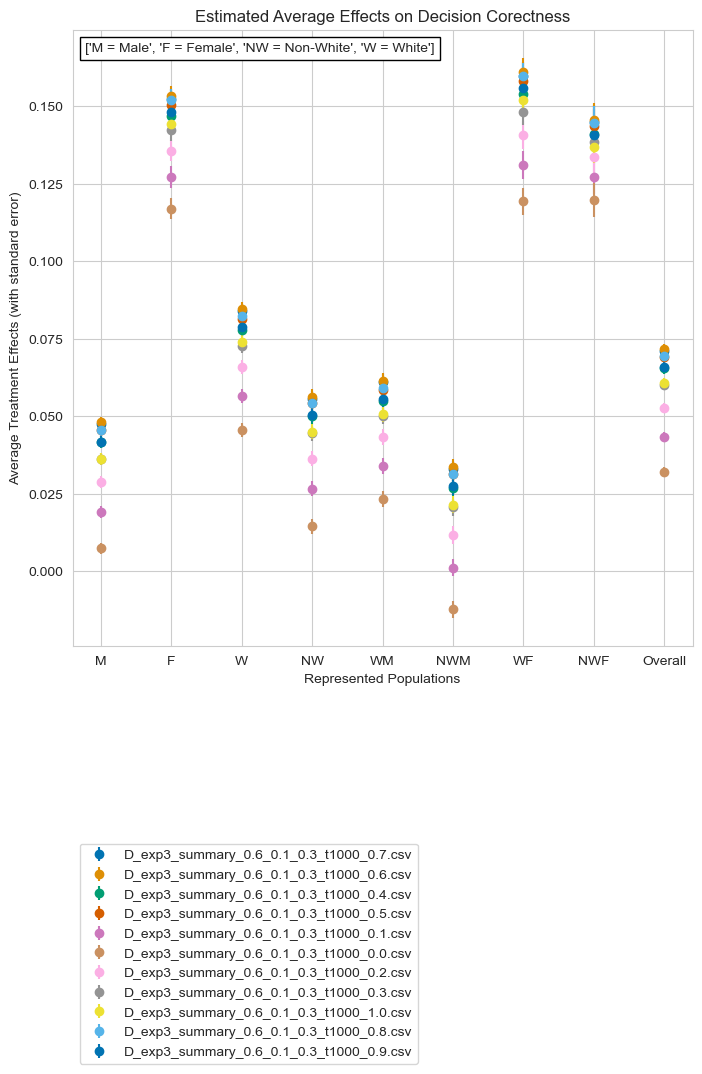

In [12]:
#plot out the change in average treatment effect on decisions and outcomes 

def stat_test(ds, val):
    '''
    Calculate p-value of treatment effect. 
    
    '''
    ds = ds.copy()

    if val == "corr_d":
     ds = ds[ds["D_corr"] != "U"]
    
    base = ds[ds["Z"] == 0]
    variant = ds[ds["Z"] == 1]
    
    if val == "y":
     ctrl_y = base[base["Y"]==1]
     ctrl_noty = base[base["Y"]==0]
     treat_y = variant[variant["Y"]==1]
     treat_noty = variant[variant["Y"]==0]

    if val == "d":
     ctrl_y = base[base["D"]==1]
     ctrl_noty = base[base["D"]==0]
     treat_y = variant[variant["D"]==1]
     treat_noty = variant[variant["D"]==0] 

    if val == "corr_d":
     ctrl_y = base[base["D_corr"]=="1.0"]
     ctrl_noty = base[base["D_corr"]=="0.0"]
     treat_y = variant[variant["D_corr"]=="1.0"]
     treat_noty = variant[variant["D_corr"]=="0.0"]   

    ty = treat_y.shape[0]
    cy = ctrl_y.shape[0]
    t_not = treat_noty.shape[0]
    c_not =ctrl_noty.shape[0]
    
    obs = np.array([[ty, cy], [t_not, c_not]])

    _, p, _, _ = chi2_contingency(obs, lambda_="log-likelihood")

    return p, obs

def estimate_uplift_y(ds):
    """
    Estiamte the difference in means between two groups.
 
    "estimated_effect" - the difference in mean values of $y$ for treated and untreated samples.
    "standard_error" - 90% confidence intervals arround "estimated_effect"
        
        
    """
    ds = ds.copy()
    base = ds[ds["Z"] == 0]
    variant = ds[ds["Z"] == 1]
    
    delta = variant["Y"].mean() - base["Y"].mean()
    delta_err = 1.96 * np.sqrt(
        variant["Y"].var() / variant.shape[0] + 
        base["Y"].var() / base.shape[0])
    
    return delta,delta_err #{"estimated_effect_y_overall": delta, "standard_error_y_overall": delta_err}

def estimate_uplift_d(ds, D_ref):
    """
    Estiamte the difference in means between two groups.
    
    "estimated_effect" - the difference in mean values of $y$ for treated and untreated samples.
    "standard_error" - 90% confidence intervals around "estimated_effect" 
        
    """
    ds = ds.copy()
    base = ds[ds["Z"] == 0]
    variant = ds[ds["Z"] == 1]
    
    delta = variant[D_ref].mean() - base[D_ref].mean()
    delta_err = 1.96 * np.sqrt(
        variant[D_ref].var() / variant.shape[0] + 
        base[D_ref].var() / base.shape[0])
    
    return delta,delta_err #{"estimated_effect_d_overall": delta, "standard_error_d_overall": delta_err}

def estimate_uplift_dcorrect(ds):
    """
    Estimate the difference in means between two groups.

    "estimated_effect" - the difference in mean values of $y$ for treated and untreated samples.
    "standard_error" - 90% confidence intervals around "estimated_effect"
        
    """
    ds = ds.copy()
    
    ds = ds[ds["D_corr"] != "U"] #Remove examples we don't know the correctness of the outcome for 
    
    base = ds[ds["Z"] == 0]
    variant = ds[ds["Z"] == 1]
    
    delta = variant["D_corr"].astype("float").mean() - base["D_corr"].astype("float").mean()
    delta_err = 1.96 * np.sqrt(
        variant["D_corr"].astype("float").var() / variant.shape[0] + 
        base["D_corr"].astype("float").var() / base.shape[0])
    
    return delta,delta_err #{"estimated_effect_dcorr_overall": delta, "standard_error_dcorr_overall": delta_err}

#Note -- break this down by demographic [M, F, W, NW, WM, NWM, WF, NWF]

def demo_est(ds, D_ref):
    '''
    Break down average treatment effect by demographic [M, F, W, NW, WM, NWM, WF, NWF]
    '''
    
    demo = {"M":{"Sex":[1], "White": [0,1]}, "F":{"Sex":[0], "White": [0,1]}, "W":{"Sex":[0,1], "White": [1]}, "NW":{"Sex":[0,1], "White": [0]}, "WM":{"Sex":[1], "White": [1]}, "NWM":{"Sex":[1], "White": [0]}, "WF":{"Sex":[0], "White": [1]}, "NWF":{"Sex":[0], "White": [0]}}
    
    res_dict = dict()
    for item in demo:
        ds_demo = ds.copy()
        print(item)
        ds_demo = ds_demo[ds_demo["Sex"].isin(demo[item]["Sex"])]
        ds_demo = ds_demo[ds_demo["White"].isin(demo[item]["White"])]

        res_dict[item] = [estimate_uplift_y(ds_demo), estimate_uplift_d(ds_demo, D_ref), estimate_uplift_dcorrect(ds_demo)]
        
    return res_dict



def get_res(df, D_ref):
    df = df.copy()
    
    res = demo_est(df, D_ref)
    res["Overall"]=[estimate_uplift_y(df), estimate_uplift_d(df, D_ref), estimate_uplift_dcorrect(df)]

    return res


import matplotlib.pyplot as plt

index={"estimated_effect_y":0, "estimated_effect_d":1, "estimated_effect_dcorr":2}


#files_exp3_1k = #["D_exp3_summary_0.6_0.1_0.3_t1000_3.csv", "D_exp3_summary_0.6_0.1_0.3_t1000_4.csv", "D_exp3_summary_0.6_0.1_0.3_t1000_5.csv", "D_exp3_summary_0.6_0.1_0.3_t1000_6.csv"]
#files_exp3_10 = ["D_exp3_summary_0.6_0.1_0.3_t10_0.1.csv", "D_exp3_summary_0.6_0.1_0.3_t10_0.2.csv", "D_exp3_summary_0.6_0.1_0.3_t10_0.3.csv", "D_exp3_summary_0.6_0.1_0.3_t10_0.4.csv", "D_exp3_summary_0.6_0.1_0.3_t10_0.5.csv", "D_exp3_summary_0.6_0.1_0.3_t10_0.6.csv", "D_exp3_summary_0.6_0.1_0.3_t10_0.7.csv", "D_exp3_summary_0.6_0.1_0.3_t10_0.8.csv", "D_exp3_summary_0.6_0.1_0.3_t10_0.9.csv", "D_exp3_summary_0.6_0.1_0.3_t10_1.0.csv"]
#files_exp2_1k = ["D_exp2_summary_0.6_0.1_0.3_t1000_3.csv", "D_exp2_summary_0.6_0.1_0.3_t1000_4.csv", "D_exp2_summary_0.6_0.1_0.3_t1000_5.csv", "D_exp2_summary_0.6_0.1_0.3_t1000_6.csv"]
#files_exp2_10 = ["D_exp2_summary_0.6_0.1_0.3_t10_3.csv", "D_exp2_summary_0.6_0.1_0.3_t10_4.csv", "D_exp2_summary_0.6_0.1_0.3_t10_5.csv", "D_exp2_summary_0.6_0.1_0.3_t10_6.csv"]
#files_exp1_10 = ["exp_summaryx_0.5_0.5_t10.csv", "exp_summaryx_0.6_0.1_0.3_t10.csv", "exp_summaryx_0.333_0.333_0.333_t10.csv", "exp_summaryx_0.999999999_1e-07_t10.csv"]
#files_exp1_1k = ["exp_summaryx_0.5_0.5_t1000.csv", "exp_summaryx_0.6_0.1_0.3_t1000.csv", "exp_summaryx_0.333_0.333_0.333_t1000.csv", "exp_summaryx_0.999999999_1e-07_t1000.csv"]

exp1_folder = "/Users/inioluwaraji/Downloads/aihuman 2 _copy copy/Experiment 1 Results/"
exp2_folder = "/Users/inioluwaraji/Downloads/aihuman 2 _copy copy/Experiment 2 Results/"
exp3_folder = "/Users/inioluwaraji/Downloads/aihuman 2 _copy copy/Experiment 3 Results/"

i = 0
fig, ax = plt.subplots(figsize=(8, 8))

for file in os.listdir(exp3_folder):

    if ("_0.6_0.1_0.3_t1000" not in file) or ("_non_linear" in file):
        continue

    exp_idx = file.split("_summary")[0]
    print(file)
    df = pd.read_csv(exp3_folder+file)
    res = get_res(df, exp_idx)
    print(stat_test(df, "y"))
    print(stat_test(df, "d"))
    print(stat_test(df, "corr_d"))
    
    a = res.keys()
    b = list()
    c = list()

    idx = index["estimated_effect_dcorr"]
    for k in res.keys():
        b.append(res[k][idx][0])
        c.append(res[k][idx][1])

    ax.errorbar(a, b, yerr=c, fmt="o", label=file) #color=colors[i],
    #plt.savefig(file+'_decisions_1k.png')
    i+=1
    
plt.title("Estimated Average Effects on Decision Corectness")
plt.xlabel("Represented Populations")
plt.ylabel("Average Treatment Effects (with standard error)")
plt.legend(loc='center left', bbox_to_anchor=(0, -0.5)) #numpoints=1, ncol=3, fontsize=8) #loc='center left', bbox_to_anchor=(1, 0.5)
#plt.tight_layout()

at = AnchoredText(['M = Male', 'F = Female', "NW = Non-White", "W = White"],
                  prop=dict(size=10), frameon=True, loc='upper left')
ax.add_artist(at)
plt.savefig('exp3_decision_correctness_1k.png', bbox_inches='tight')
plt.show()